# Automatic Generation of Design Structure Matrices

by James Gopsill

![Alt Text](top_image.png "Automatic DSM")

<hr>

Design Structure Matrices (DSMs) have been extensively applied to identify and visualise product & organisational architectures across a number of engineering disciplines. They provide a crucial insight into potential interactions within engineering projects. They not only cover component dependencies but also process, system and organisational dependencieces.

Historically, the generation of a DSM typically involves surveys, structured interviews and/or
meetings with engineers involved on the project. As a consequence, there is a high cost associated
with engineers' time alongside the requirement to continually update the DSM
structure as a product develops.

Therefore, investigations have been performed into the viability of capturing and monitoring edits to project files could be used to automatically generate DSMs (Gopsill et al., 2016, ).

This python notebook takes you through the steps that these researchers have gone through in order to generate DSMs automatically from file meta-data and serves to act as an introduction for anyone who wishes to explore this field of research further.

The example uses an anonymised subset of metadata changes captured and used in the study by Gopsill et al., (2016). The data comes in the format of an SQLite database, which contains 541 unique part models and 4601 metadata changes. The full dataset used in the studies consisted of over 1,431 part models and 10,145 metadata changes and was stored within a MySQL databases.

Before we begin, we need to load in the necessary packages.

In [2]:
# A line of code that jupyter notebook uses to plot the images inline with the code and text
%matplotlib inline
# Custom settings for the python notebook to save images as svg rather than png
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import sqlite3
import pprint
from datetime import datetime, timedelta
import operator

## Loading the SQL Data

Now we have all the packages imported, we can load up our SQLite database. We can then query the database to provide an example of the data stored within the table 'metadata' and the number of rows that the table contains.

In [3]:
conn = sqlite3.connect('example.db')
cur = conn.cursor()

pp = pprint.PrettyPrinter(indent=2)

# Present an example output from the database
cur.execute(" SELECT file_name, date_modified FROM metadata LIMIT 5")
results = cur.fetchall()
pp.pprint(results)

cur.execute(" SELECT COUNT(*) FROM metadata")
number_of_rows = cur.fetchone()[0]
print('Number of Metadata Changes', number_of_rows)


[ ('Complete - Assembly - 1', '2009-11-09 21:36:50'),
  ('Complete - Assembly - 1', '2010-11-03 22:06:00'),
  ('Complete - Assembly - 1', '2010-11-03 22:45:48'),
  ('Complete - Assembly - 1', '2010-11-04 18:53:27'),
  ('Complete - Assembly - 1', '2010-11-04 22:11:46')]
Number of Metadata Changes 4609


## Creating the list of parts and nodes for network

To create the network, find all the uniqiue file names and also count how many changes that have been made to the files. From this, we can start to build up a network of nodes with each node representing a unique file from the database. We also form a list of file names and this order matches the indexes that we have used for the nodes in the network.

In [4]:
# Select all the file_names and count the number of times they have occurred, group by file_name
cur.execute(" SELECT file_name, COUNT(*) as count FROM metadata GROUP BY file_name")
# Retrieve the results
results = cur.fetchall()

file_names = [] # Empty list for indexing the file names
g = nx.Graph() # empty network object

# loop through each row in the results and create a node in the network
for i, result in enumerate(results):
    file_names.append(result[0]) # append name to list
    g.add_node(i, # index node
              file_name=result[0], # provide name attribute to node
              freq=result[1] # store the number of occurrences of the file
              )

pp.pprint(file_names[0:10])
print('Number of Nodes:', g.number_of_nodes())


[ 'Brake - Assembly - 2',
  'Brake - Assembly - 3',
  'Brake - Assembly - 4',
  'Brake - Assembly - 5',
  'Brake - Assembly - 6',
  'Brake - Assembly - 7',
  'Brake - Component - 10',
  'Brake - Component - 4',
  'Brake - Component - 5',
  'Brake - Component - 6']
Number of Nodes: 541


## Adding the Edges

Now we have all the nodes within our network, we need to start associating them with another by making edges that link them together. The main hypothesis of this work is that CAD files that change within a certain time period of one another are candidates for a likely dependency. The more times the file change within one anothers time frames, the more likely (and poetentially the stronger) the dependency will be.

In this example, we will record any changes to files within a 3 hour maximum time window of the file of interest changing. We will also keep the network undirected and the results from paper reveal thats many of the dependencies are reciprocated between files (i.e. if file A changes and B changes as a result, then if file B changes, file A is likely to change too).

Using this time window, we loop through each file and retrieve all the dates it has been modified. We then run through each modified date and create the 3 hour time window that will search within. However, we also perform a check to see whether the subsequent file change lies within this window. If so, the window is reduced to fit within the two modified dates. We do this to avoid double counting of the files changing.

Once the window has been defined, a query is performed on the metadata to identify all the files that have changed within the window. We then iterate the results and either, create an edge if one does not already exist or we increase the weight of the existing edge.

In [5]:
time_delta = timedelta(hours=3) # Setting the max time window

# for each file name in the network
for i, file_name in enumerate(file_names):
    # retrieve all the modified dates
    cur.execute("SELECT date_modified FROM metadata WHERE file_name = ? ORDER BY date_modified ASC", (file_name,))
    results = cur.fetchall()
    
    # create a list of modified dates from the results and turn them into date times
    dates_modified = []
    for result in results:
        dates_modified.append(datetime.strptime( result[0], '%Y-%m-%d %H:%M:%S' ))
        
    number_of_rows = len(dates_modified)
    # for each modified date
    for n in range(0, number_of_rows-1):
        # Setting the time window
        start_date = dates_modified[n]
        end_date = start_date + time_delta
        if n == number_of_rows-1: # if the date modified date is not the last in the list
            if end_date > dates_modified[n+1]: # Check if the subsequent if less than the maximum time window
                end_date = dates_modified[n+1] # use the subsequent data modified rather than the 3 hour time window

        # get the parts that have been modified in that time span
        cur.execute("SELECT file_name FROM metadata WHERE date_modified > ? and date_modified < ? GROUP BY file_name", (start_date, end_date))
        results = cur.fetchall()

        # Iterate through the results and add edges & weightings accordingly
        for result in results:
            file_idx = file_names.index(result[0])
            if g.has_edge(i, file_idx):
                g[i][file_idx]['weight'] = g[i][file_idx]['weight'] + 1
            else:
                g.add_edge(i, file_idx, weight=1)

# close the connection to the database as we no longer need it
conn.close()
                
print('Number of Nodes:', g.number_of_nodes())
print('Number of Edges:', g.number_of_edges())


Number of Nodes: 541
Number of Edges: 62091


## Initial Results

### Plotting the matrix

[[ 2.  3.  3. ...,  2.  2.  2.]
 [ 3.  1.  2. ...,  1.  1.  1.]
 [ 3.  2.  1. ...,  1.  1.  1.]
 ..., 
 [ 2.  1.  1. ...,  1.  4.  3.]
 [ 2.  1.  1. ...,  4.  1.  3.]
 [ 2.  1.  1. ...,  3.  3.  0.]]
120.0


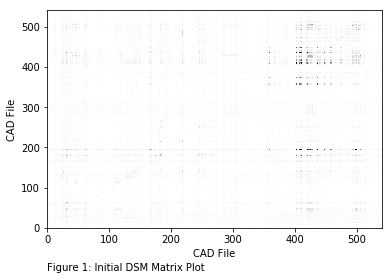

In [6]:
m = nx.to_numpy_matrix(g)
m = np.asarray(m)
print(m)
print(np.max(m))

# Return to png for plotting results as these are large arrays and large svgs will crash the page
set_matplotlib_formats('png')

plt.pcolor(m, cmap='Greys', vmin=0, vmax=np.max(m)/2)
plt.xlim(0, g.number_of_nodes())
plt.ylim(0, g.number_of_nodes())
plt.xlabel('CAD File')
plt.ylabel('CAD File')
plt.annotate('Figure 1: Initial DSM Matrix Plot', (0,0), (0, -35), xycoords='axes fraction', textcoords='offset points', va='top')
plt.show()

### Plotting Edge Weights

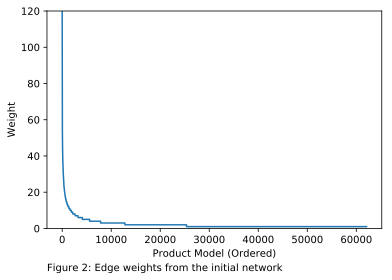

In [7]:
edge_weights = []
for u, v, d in g.edges(data=True):
    edge_weights.append(d['weight'])

edge_weights.sort(reverse=True)

set_matplotlib_formats('pdf', 'svg')
plt.plot(edge_weights)
plt.ylim(0, edge_weights[0])
plt.xlabel('Product Model (Ordered)')
plt.ylabel('Weight')
plt.annotate('Figure 2: Edge weights from the initial network', (0,0), (0, -35), xycoords='axes fraction', textcoords='offset points', va='top')
plt.show()

### Plotting Node Frequencies

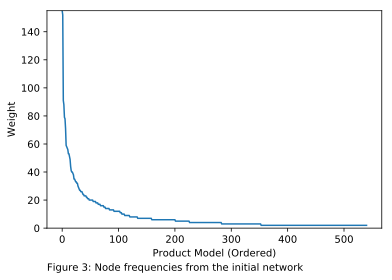

In [8]:
node_freqs = []
for u, d in g.nodes(data=True):
    node_freqs.append(d['freq'])

node_freqs.sort(reverse=True)

set_matplotlib_formats('pdf', 'svg')
plt.plot(node_freqs)
plt.ylim(0, node_freqs[0])
plt.xlabel('Product Model (Ordered)')
plt.ylabel('Weight')
plt.annotate('Figure 3: Node frequencies from the initial network', (0,0), (0, -35), xycoords='axes fraction', textcoords='offset points', va='top')
plt.show()

## Matrix Normalisation

The initial results show the potential dependencies through a pure count of the number of times the files have changed within the time-frames of others. This inherently biases towards files with lots of changes. Therefore, an element of normalisation needs to occur. In this case the weighting of the edge is divided by the combined frequencies of changes of the two files of interest. This normalises between 0 and 1 with 1 being scored when everytime a change occurs within either file, the other file changes soon after.

Figure 4 shows that the normalisation of the edge weights has a significant effect on their distribution and shows the some of the edges are much more influential than previously thought.

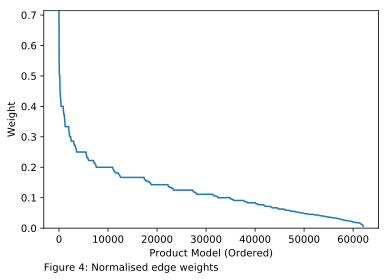

In [9]:
new_edge_weights = []
for u, v, d in g.edges(data=True):
    g[u][v]['weight'] = float( g[u][v]['weight'] ) / ( float(g.node[u]['freq']) + float(g.node[v]['freq']) )
    new_edge_weights.append(g[u][v]['weight'])

new_edge_weights.sort(reverse=True)

set_matplotlib_formats('pdf', 'svg')
plt.plot(new_edge_weights)
plt.ylim(0, new_edge_weights[0])
plt.xlabel('Product Model (Ordered)')
plt.ylabel('Weight')
plt.annotate('Figure 4: Normalised edge weights', (0,0), (0, -35), xycoords='axes fraction', textcoords='offset points', va='top')
plt.show()

## Prune Matrix

Now that we have a normalised matrix, we can start to remove any edges and nodes that have a minimal contribution to the network and therefore, potentially have little influence on the changes that are occurring to the product models. In addition, as we are looking at metadata file changes, it is likely that some associations may have occurred as the files have been collaboratively worked upon during the same time-frame and actually, no dependency is present between the models.

The pruning first removes any edges that have a low weighting attached to them. This has been set to 0.25 in this demo. Second, any product model with less then three changes made to it is also removed. It is deemed that there are too little changes in order for us to resolve a likely dependency from. Third, we loop through the network and remove any product models that contain a single edge to the rest of the network. This removes any product models that have little connection to the rest and maintains the dense core of highly-dependent product models.


In [10]:
# remove low weighted edges
edges_to_remove = []
for u, v, d in g.edges(data=True):
  if d['weight'] < 0.25:
    edges_to_remove.append([u, v])

for u, v in edges_to_remove:
    g.remove_edge(u, v)

print('- Pruned Edges -')
print('Number of Nodes:', g.number_of_nodes())
print('Number of Edges:', g.number_of_edges())

nodes_to_remove = []
for u, d in g.nodes(data=True):
  if d['freq'] < 3:
    nodes_to_remove.append(u)
    
for u in nodes_to_remove:
    g.remove_node(u)
    
print('- Pruned Node -')
print('Number of Nodes:', g.number_of_nodes())
print('Number of Edges:', g.number_of_edges())
    
# check for any leftover nodes with no 
n = 0
keep_running = True
nodes_to_remove = []
while keep_running:
    n = n + 1
    print('Iteration:', n)
    keep_running = False
    nodes_to_remove = []
    for u in g.nodes():
        if g.degree(u) < 2:
            nodes_to_remove.append(u)
    
    if nodes_to_remove:
        keep_running = True
        for u in nodes_to_remove:
            g.remove_node(u)
            
print('- Pruned Low Degree -')
print('Number of Nodes:', g.number_of_nodes())
print('Number of Edges:', g.number_of_edges())

- Pruned Edges -
Number of Nodes: 541
Number of Edges: 5522
- Pruned Node -
Number of Nodes: 353
Number of Edges: 3167
Iteration: 1
Iteration: 2
- Pruned Low Degree -
Number of Nodes: 348
Number of Edges: 3164


## Visualising the matrix

This results in a pruned normalised network, which is depicted in Figure 5. It can be seen that the matric is relatively sparse and in its current format, it is difficult to identify any highly grouped product model that are likely to be dependent on one another. Therefore, we continue the analysis by clustering the matrix in order to uncover these groups.

[[ 0.25        0.42857143  0.42857143 ...,  0.25        0.25        0.28571429]
 [ 0.42857143  0.          0.33333333 ...,  0.          0.          0.        ]
 [ 0.42857143  0.33333333  0.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.25        0.          0.         ...,  0.          0.5         0.42857143]
 [ 0.25        0.          0.         ...,  0.5         0.          0.42857143]
 [ 0.28571429  0.          0.         ...,  0.42857143  0.42857143  0.        ]]


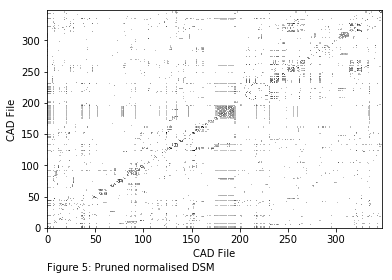

In [11]:
m = nx.to_numpy_matrix(g)
m = np.asarray(m)
print(m)

# Return to png for plotting results as these are large arrays and large svgs will crash the page
set_matplotlib_formats('png')

plt.pcolor(m, cmap='Greys', vmin=0, vmax=np.max(m))
plt.xlim(0, g.number_of_nodes())
plt.ylim(0, g.number_of_nodes())
plt.xlabel('CAD File')
plt.ylabel('CAD File')
plt.annotate('Figure 5: Pruned normalised DSM', (0,0), (0, -35), xycoords='axes fraction', textcoords='offset points', va='top')
plt.show()

## Clustering highly dependent models

In order to identify the groupd of highly-dependent models (and most likely the key sub-systems that we have to monitor and be aware of) we apply the [Louvain Community detection algorithm](http://perso.crans.org/aynaud/communities/) ([Blondel et al., 2008](http://arxiv.org/pdf/0803.0476.pdf); [Wiki](https://en.wikipedia.org/wiki/Louvain_Modularity)).

The Louvain community algorithms' objective is to generate a set of clusters for the matrix that returns the highest modularity value. Modularity ($Q$) is an assessment of the quality of the matrix partition and is defined as [Newman (2004)](http://arxiv.org/pdf/cond-mat/0407503v1.pdf):


$$ Q = \frac{1}{2m}\sum_{ij}\bigg[A_{ij}-\frac{k_ik_j}{2m}\bigg]\delta(c_i,c_j) $$

Where $ m = \frac{1}{2}\sum_{ij}A_{ij} $ and is the number of co-occurrences within the matrix. $\delta$ is the Kronecker delta function and is 1 if a co-occurrence exists between two models and 0 otherwise. $ \frac{k_ik_j}{2m} $ is the probability that a co-occurrence may exist between two models, where $ k_i $ is the number of models that have co-occurrences with model $i$ and $ k_j $ is the number of models that have co-occurrences with model $j$. And, $A_{ij}$ is the weighted co-occurrence between two models in the matrix.

In order to obtain the highest modularity clustering, the algorithm iterates between two steps. The first assigns each model to its own cluster. This is then followed by the algorithm sequentially moving one model to a different cluster and calculating the change in modularity. From this, the maximum modularity change can be identified.

The second step merges the models together to form a cluster of models and combines the co-occurrences of model activity to form single co-occurrence links to the rest of the matrix and self-loops are used to identify internal co-occurrences between the models within the partition. The aim is to achieve a partitioning whereby each partition is highly connected internally and weakly connected to one another.

In this example, 9 clusters have been identified by the algorithm and the network drawn in Figure 4 has the nodes colour coded relation to these clusters. The associated modularity score of 0.56 indicates that an underlying structure does exist within the network and is higher than 0.3, which is considered a 'good' level of partitioning.

Number of Communities: 9
Modularity: 0.5578775190798851
Number of Components: 1


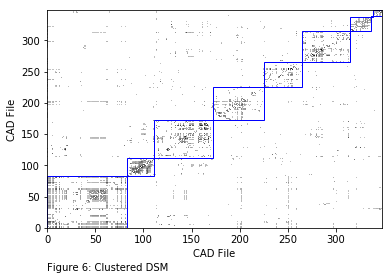

In [12]:
# cluster analysis
partition = best_partition(g)
number_of_communities = len(list(set([k for k in partition.values()]))) # get number of communities
print('Number of Communities:', number_of_communities)
mod = modularity(partition, g)
print('Modularity:', mod)
print('Number of Components:', nx.number_connected_components(g))

sortedPartition = sorted(partition.items(), key=operator.itemgetter(1))

# create a new matrix from the partition
n = np.zeros( ( g.number_of_nodes(), g.number_of_nodes() ) )

for u, v, d in g.edges(data=True):
    for i, item in enumerate(sortedPartition):
        if item[0] == u: break
        
    for j, item in enumerate(sortedPartition):
        if item[0] == v: break
                
    n[i, j] = d['weight']
    n[j, i] = d['weight']

plt.pcolor(n, cmap='Greys', vmin=0, vmax=np.max(m))
plt.xlim(0, g.number_of_nodes())
plt.ylim(0, g.number_of_nodes())
plt.xlabel('CAD File')
plt.ylabel('CAD File')

# adding the rectangles
currentAxis = plt.gca()

start_position = 0
cluster = 0
length = 0
for idx, item in enumerate(sortedPartition):
    #print(idx, item[0], item[1])
    if item[1] != cluster:
        #print('new cluster detected')
        currentAxis.add_patch(Rectangle((start_position, start_position), length, length, facecolor="none", edgecolor='blue', linewidth=1))
        start_position = idx
        cluster = item[1]
        length = 1
    else:
        length = length + 1

# this is the last rectangle
currentAxis.add_patch(Rectangle((start_position, start_position), length, length, facecolor="none", edgecolor='blue', linewidth=1))
plt.annotate('Figure 6: Clustered DSM', (0,0), (0, -35), xycoords='axes fraction', textcoords='offset points', va='top')
plt.show()

In addition to identifying clusters, we can look at the composition of the clusters in relation to the sub-systems as defined by the team Product Lifecycle Management system. Figure 7 shows the cluster composition and it can be seen that many of the clusters consists of components from multiple sub-systems. This highlights the potential for the analysis to identify dependencies across pre-defined sub-system boundaries. In addition, the size of the cluster highlights the potential impact a change would have and the level of work required to implement the change.

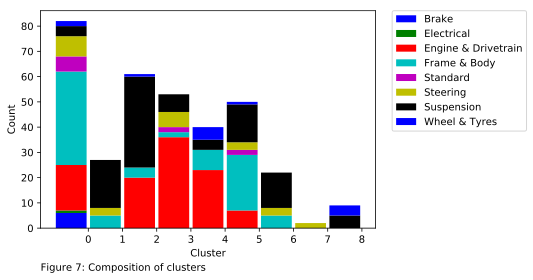

In [13]:
# A list of model types that we're interested in
file_types = [
    'Brake',
    'Electrical',
    'Engine & Drivetrain',
    'Frame & Body',
    'Standard',
    'Steering',
    'Suspension',
    'Wheel & Tyres'
]

# previous columns in our bar chart
previous_cols = np.zeros( (number_of_communities, 1) )
# indices for the columns
ind = np.arange(0, number_of_communities)

colors = 'bgrcmykbgrcmykbgrcmykbgrcmyk'

# for each file type
for i, file_type in enumerate(file_types):
    # create a set of cols that will contain the values for the number of times the file type appears in each cluster
    current_cols = np.zeros( (number_of_communities, 1) )
    
    # run through the clusters
    for file_id, cluster_id in sortedPartition:
        # if the file is of the type we're interested in
        if file_type in file_names[file_id]:
            # added one to the column
            current_cols[cluster_id,0] = current_cols[cluster_id,0] + 1
    
    #plot the column
    plt.bar(ind, current_cols, width=0.9, bottom=previous_cols, color=colors[i], label=file_type)
    # add the current column to the previous column
    previous_cols = current_cols + previous_cols

set_matplotlib_formats('pdf', 'svg')
plt.xticks(ind + 0.5, ind)
plt.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.annotate('Figure 7: Composition of clusters', (0,0), (0, -35), xycoords='axes fraction', textcoords='offset points', va='top')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

## Continued Work

This notebook has demonstrated how you can automatiaclly generated a DSM from the metadata changes of product models. Our work is continuing on identifying the most appropriate level of pruning and the validity of the clusters that have been created. A key advantage of generating DSMs in this manner is that it can be automatically generated and updated in real-time. We are currently exploring this further to understand how dependencies are form and evolve over the course of engineering projects. As the analysis involves only the metadata of the files, this technique could be applied across any and/or all files being generated throughout an engineering project and thus, be used to identify dependencies across fields such as FEA & CFD. The results fo which could be used to support the management of current and future projects as well as engineering activities such as generating a FMECA.

In [14]:
"""
This module implements community detection.
"""
from __future__ import print_function
__all__ = ["partition_at_level", "modularity", "best_partition", "generate_dendrogram", "generate_dendogram", "induced_graph"]
__author__ = """Thomas Aynaud (thomas.aynaud@lip6.fr)"""
#    Copyright (C) 2009 by
#    Thomas Aynaud <thomas.aynaud@lip6.fr>
#    All rights reserved.
#    BSD license.

__PASS_MAX = -1
__MIN = 0.0000001

import networkx as nx
import sys
import types
import array


def partition_at_level(dendrogram, level) :
    """Return the partition of the nodes at the given level

    A dendrogram is a tree and each level is a partition of the graph nodes.
    Level 0 is the first partition, which contains the smallest communities, and the best is len(dendrogram) - 1.
    The higher the level is, the bigger are the communities

    Parameters
    ----------
    dendrogram : list of dict
       a list of partitions, ie dictionnaries where keys of the i+1 are the values of the i.
    level : int
       the level which belongs to [0..len(dendrogram)-1]

    Returns
    -------
    partition : dictionnary
       A dictionary where keys are the nodes and the values are the set it belongs to

    Raises
    ------
    KeyError
       If the dendrogram is not well formed or the level is too high

    See Also
    --------
    best_partition which directly combines partition_at_level and generate_dendrogram to obtain the partition of highest modularity

    Examples
    --------
    >>> G=nx.erdos_renyi_graph(100, 0.01)
    >>> dendo = generate_dendrogram(G)
    >>> for level in range(len(dendo) - 1) :
    >>>     print "partition at level", level, "is", partition_at_level(dendo, level)
    """
    partition = dendrogram[0].copy()
    for index in range(1, level + 1) :
        for node, community in partition.items() :
            partition[node] = dendrogram[index][community]
    return partition


def modularity(partition, graph) :
    """Compute the modularity of a partition of a graph

    Parameters
    ----------
    partition : dict
       the partition of the nodes, i.e a dictionary where keys are their nodes and values the communities
    graph : networkx.Graph
       the networkx graph which is decomposed

    Returns
    -------
    modularity : float
       The modularity

    Raises
    ------
    KeyError
       If the partition is not a partition of all graph nodes
    ValueError
        If the graph has no link
    TypeError
        If graph is not a networkx.Graph

    References
    ----------
    .. 1. Newman, M.E.J. & Girvan, M. Finding and evaluating community structure in networks. Physical Review E 69, 26113(2004).

    Examples
    --------
    >>> G=nx.erdos_renyi_graph(100, 0.01)
    >>> part = best_partition(G)
    >>> modularity(part, G)
    """
    if type(graph) != nx.Graph :
        raise TypeError("Bad graph type, use only non directed graph")

    inc = dict([])
    deg = dict([])
    links = graph.size(weight='weight')
    if links == 0 :
        raise ValueError("A graph without link has an undefined modularity")

    for node in graph :
        com = partition[node]
        deg[com] = deg.get(com, 0.) + graph.degree(node, weight = 'weight')
        for neighbor, datas in graph[node].items() :
            weight = datas.get("weight", 1)
            if partition[neighbor] == com :
                if neighbor == node :
                    inc[com] = inc.get(com, 0.) + float(weight)
                else :
                    inc[com] = inc.get(com, 0.) + float(weight) / 2.

    res = 0.
    for com in set(partition.values()) :
        res += (inc.get(com, 0.) / links) - (deg.get(com, 0.) / (2.*links))**2
    return res


def best_partition(graph, partition = None) :
    """Compute the partition of the graph nodes which maximises the modularity
    (or try..) using the Louvain heuristices

    This is the partition of highest modularity, i.e. the highest partition of the dendrogram
    generated by the Louvain algorithm.

    Parameters
    ----------
    graph : networkx.Graph
       the networkx graph which is decomposed
    partition : dict, optionnal
       the algorithm will start using this partition of the nodes. It's a dictionary where keys are their nodes and values the communities

    Returns
    -------
    partition : dictionnary
       The partition, with communities numbered from 0 to number of communities

    Raises
    ------
    NetworkXError
       If the graph is not Eulerian.

    See Also
    --------
    generate_dendrogram to obtain all the decompositions levels

    Notes
    -----
    Uses Louvain algorithm

    References
    ----------
    .. 1. Blondel, V.D. et al. Fast unfolding of communities in large networks. J. Stat. Mech 10008, 1-12(2008).

    Examples
    --------
    >>>  #Basic usage
    >>> G=nx.erdos_renyi_graph(100, 0.01)
    >>> part = best_partition(G)

    >>> #other example to display a graph with its community :
    >>> #better with karate_graph() as defined in networkx examples
    >>> #erdos renyi don't have true community structure
    >>> G = nx.erdos_renyi_graph(30, 0.05)
    >>> #first compute the best partition
    >>> partition = community.best_partition(G)
    >>>  #drawing
    >>> size = float(len(set(partition.values())))
    >>> pos = nx.spring_layout(G)
    >>> count = 0.
    >>> for com in set(partition.values()) :
    >>>     count = count + 1.
    >>>     list_nodes = [nodes for nodes in partition.keys()
    >>>                                 if partition[nodes] == com]
    >>>     nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                    node_color = str(count / size))
    >>> nx.draw_networkx_edges(G,pos, alpha=0.5)
    >>> plt.show()
    """
    dendo = generate_dendrogram(graph, partition)
    return partition_at_level(dendo, len(dendo) - 1 )


def generate_dendogram(graph, part_init = None) :
    """Deprecated, use generate_dendrogram"""
    return generate_dendrogram(graph, part_init)
    
    
def generate_dendrogram(graph, part_init = None) :
    """Find communities in the graph and return the associated dendrogram

    A dendrogram is a tree and each level is a partition of the graph nodes.  Level 0 is the first partition, which contains the smallest communities, and the best is len(dendrogram) - 1. The higher the level is, the bigger are the communities


    Parameters
    ----------
    graph : networkx.Graph
        the networkx graph which will be decomposed
    part_init : dict, optionnal
        the algorithm will start using this partition of the nodes. It's a dictionary where keys are their nodes and values the communities

    Returns
    -------
    dendrogram : list of dictionaries
        a list of partitions, ie dictionnaries where keys of the i+1 are the values of the i. and where keys of the first are the nodes of graph

    Raises
    ------
    TypeError
        If the graph is not a networkx.Graph

    See Also
    --------
    best_partition

    Notes
    -----
    Uses Louvain algorithm

    References
    ----------
    .. 1. Blondel, V.D. et al. Fast unfolding of communities in large networks. J. Stat. Mech 10008, 1-12(2008).

    Examples
    --------
    >>> G=nx.erdos_renyi_graph(100, 0.01)
    >>> dendo = generate_dendrogram(G)
    >>> for level in range(len(dendo) - 1) :
    >>>     print "partition at level", level, "is", partition_at_level(dendo, level)
    """
    if type(graph) != nx.Graph :
        raise TypeError("Bad graph type, use only non directed graph")

    #special case, when there is no link
    #the best partition is everyone in its community
    if graph.number_of_edges() == 0 :
        part = dict([])
        for node in graph.nodes() :
            part[node] = node
        return part

    current_graph = graph.copy()
    status = Status()
    status.init(current_graph, part_init)
    mod = __modularity(status)
    status_list = list()
    __one_level(current_graph, status)
    new_mod = __modularity(status)
    partition = __renumber(status.node2com)
    status_list.append(partition)
    mod = new_mod
    current_graph = induced_graph(partition, current_graph)
    status.init(current_graph)

    while True :
        __one_level(current_graph, status)
        new_mod = __modularity(status)
        if new_mod - mod < __MIN :
            break
        partition = __renumber(status.node2com)
        status_list.append(partition)
        mod = new_mod
        current_graph = induced_graph(partition, current_graph)
        status.init(current_graph)
    return status_list[:]


def induced_graph(partition, graph) :
    """Produce the graph where nodes are the communities

    there is a link of weight w between communities if the sum of the weights of the links between their elements is w

    Parameters
    ----------
    partition : dict
       a dictionary where keys are graph nodes and  values the part the node belongs to
    graph : networkx.Graph
        the initial graph

    Returns
    -------
    g : networkx.Graph
       a networkx graph where nodes are the parts

    Examples
    --------
    >>> n = 5
    >>> g = nx.complete_graph(2*n)
    >>> part = dict([])
    >>> for node in g.nodes() :
    >>>     part[node] = node % 2
    >>> ind = induced_graph(part, g)
    >>> goal = nx.Graph()
    >>> goal.add_weighted_edges_from([(0,1,n*n),(0,0,n*(n-1)/2), (1, 1, n*(n-1)/2)])
    >>> nx.is_isomorphic(int, goal)
    True
    """
    ret = nx.Graph()
    ret.add_nodes_from(partition.values())

    for node1, node2, datas in graph.edges(data = True) :
        weight = datas.get("weight", 1)
        com1 = partition[node1]
        com2 = partition[node2]
        w_prec = ret.get_edge_data(com1, com2, {"weight":0}).get("weight", 1)
        ret.add_edge(com1, com2, weight = w_prec + weight)

    return ret


def __renumber(dictionary) :
    """Renumber the values of the dictionary from 0 to n
    """
    count = 0
    ret = dictionary.copy()
    new_values = dict([])

    for key in dictionary.keys() :
        value = dictionary[key]
        new_value = new_values.get(value, -1)
        if new_value == -1 :
            new_values[value] = count
            new_value = count
            count = count + 1
        ret[key] = new_value

    return ret


def __load_binary(data) :
    """Load binary graph as used by the cpp implementation of this algorithm
    """
    data = open(data, "rb")

    reader = array.array("I")
    reader.fromfile(data, 1)
    num_nodes = reader.pop()
    reader = array.array("I")
    reader.fromfile(data, num_nodes)
    cum_deg = reader.tolist()
    num_links = reader.pop()
    reader = array.array("I")
    reader.fromfile(data, num_links)
    links = reader.tolist()
    graph = nx.Graph()
    graph.add_nodes_from(range(num_nodes))
    prec_deg = 0

    for index in range(num_nodes) :
        last_deg = cum_deg[index]
        neighbors = links[prec_deg:last_deg]
        graph.add_edges_from([(index, int(neigh)) for neigh in neighbors])
        prec_deg = last_deg

    return graph


def __one_level(graph, status) :
    """Compute one level of communities
    """
    modif = True
    nb_pass_done = 0
    cur_mod = __modularity(status)
    new_mod = cur_mod

    while modif  and nb_pass_done != __PASS_MAX :
        cur_mod = new_mod
        modif = False
        nb_pass_done += 1

        for node in graph.nodes() :
            com_node = status.node2com[node]
            degc_totw = status.gdegrees.get(node, 0.) / (status.total_weight*2.)
            neigh_communities = __neighcom(node, graph, status)
            __remove(node, com_node,
                    neigh_communities.get(com_node, 0.), status)
            best_com = com_node
            best_increase = 0
            for com, dnc in neigh_communities.items() :
                incr =  dnc  - status.degrees.get(com, 0.) * degc_totw
                if incr > best_increase :
                    best_increase = incr
                    best_com = com
            __insert(node, best_com,
                    neigh_communities.get(best_com, 0.), status)
            if best_com != com_node :
                modif = True
        new_mod = __modularity(status)
        if new_mod - cur_mod < __MIN :
            break


class Status :
    """
    To handle several data in one struct.

    Could be replaced by named tuple, but don't want to depend on python 2.6
    """
    node2com = {}
    total_weight = 0
    internals = {}
    degrees = {}
    gdegrees = {}

    def __init__(self) :
        self.node2com = dict([])
        self.total_weight = 0
        self.degrees = dict([])
        self.gdegrees = dict([])
        self.internals = dict([])
        self.loops = dict([])

    def __str__(self) :
        return ("node2com : " + str(self.node2com) + " degrees : "
            + str(self.degrees) + " internals : " + str(self.internals)
            + " total_weight : " + str(self.total_weight))

    def copy(self) :
        """Perform a deep copy of status"""
        new_status = Status()
        new_status.node2com = self.node2com.copy()
        new_status.internals = self.internals.copy()
        new_status.degrees = self.degrees.copy()
        new_status.gdegrees = self.gdegrees.copy()
        new_status.total_weight = self.total_weight

    def init(self, graph, part = None) :
        """Initialize the status of a graph with every node in one community"""
        count = 0
        self.node2com = dict([])
        self.total_weight = 0
        self.degrees = dict([])
        self.gdegrees = dict([])
        self.internals = dict([])
        self.total_weight = graph.size(weight = 'weight')
        if part == None :
            for node in graph.nodes() :
                self.node2com[node] = count
                deg = float(graph.degree(node, weight = 'weight'))
                if deg < 0 :
                    raise ValueError("Bad graph type, use positive weights")
                self.degrees[count] = deg
                self.gdegrees[node] = deg
                self.loops[node] = float(graph.get_edge_data(node, node,
                                                 {"weight":0}).get("weight", 1))
                self.internals[count] = self.loops[node]
                count = count + 1
        else :
            for node in graph.nodes() :
                com = part[node]
                self.node2com[node] = com
                deg = float(graph.degree(node, weight = 'weight'))
                self.degrees[com] = self.degrees.get(com, 0) + deg
                self.gdegrees[node] = deg
                inc = 0.
                for neighbor, datas in graph[node].items() :
                    weight = datas.get("weight", 1)
                    if weight <= 0 :
                        raise ValueError("Bad graph type, use positive weights")
                    if part[neighbor] == com :
                        if neighbor == node :
                            inc += float(weight)
                        else :
                            inc += float(weight) / 2.
                self.internals[com] = self.internals.get(com, 0) + inc



def __neighcom(node, graph, status) :
    """
    Compute the communities in the neighborood of node in the graph given
    with the decomposition node2com
    """
    weights = {}
    for neighbor, datas in graph[node].items() :
        if neighbor != node :
            weight = datas.get("weight", 1)
            neighborcom = status.node2com[neighbor]
            weights[neighborcom] = weights.get(neighborcom, 0) + weight

    return weights


def __remove(node, com, weight, status) :
    """ Remove node from community com and modify status"""
    status.degrees[com] = ( status.degrees.get(com, 0.)
                                    - status.gdegrees.get(node, 0.) )
    status.internals[com] = float( status.internals.get(com, 0.) -
                weight - status.loops.get(node, 0.) )
    status.node2com[node] = -1


def __insert(node, com, weight, status) :
    """ Insert node into community and modify status"""
    status.node2com[node] = com
    status.degrees[com] = ( status.degrees.get(com, 0.) +
                                status.gdegrees.get(node, 0.) )
    status.internals[com] = float( status.internals.get(com, 0.) +
                        weight + status.loops.get(node, 0.) )


def __modularity(status) :
    """
    Compute the modularity of the partition of the graph faslty using status precomputed
    """
    links = float(status.total_weight)
    result = 0.
    for community in set(status.node2com.values()) :
        in_degree = status.internals.get(community, 0.)
        degree = status.degrees.get(community, 0.)
        if links > 0 :
            result = result + in_degree / links - ((degree / (2.*links))**2)
    return result